<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PAC3
</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitari en Ciencia de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 3: Recurrent Neural Networks - Joaquim Quadrada Jané

En aquesta pràctica implementarem xarxes neuronals recurrents per generar música.

**Important: El lliurament s'ha de fer en format notebook i en format html on es vegi el codi i els resultats i comentaris de cada exercici. Per exportar el notebook a html es pot fer des del menú File $\to$ Download as $\to$ HTML.**

# 0. Context i referències

Aquesta PAC es basa en el següent [article de recerca](https://arxiv.org/pdf/1711.07682.pdf), encara que per motius d'extensió no podrem passar per tots els punts de l'article.

La primera etapa d'aquesta PAC serà llegir i entendre la idea general d'aquest treball. L'article us dóna accés al codi original amb què s'ha dut a terme el treball i en què a més està basat gran part del codi que aquí us adjuntem, encara que per la complexitat i extensió del codi no us recomanem que us fiqueu massa en ell.

La PAC consta d'una etapa d'interpretació de les dades (un pas vital en tot projecte real), on es demanarà reproduir una gràfica de l'article. Després ***entrenarem*** una xarxa LSTM per generar acords a partir de fitxers MIDI. Finalment, farem servir la capa de ***embedding*** de la xarxa entrenada per fer una projecció dels acords en 2D i visualitzar el concepte de [word2vec](https://en.wikipedia.org/wiki/Word2vec).

A més d'aquest fitxer us hem adjuntat un arxiu comprimit amb una estructura de dades similar a la usada a l'article i que us recomanem (pel vostre bé) que no modifiqueu :). Allà trobareu una carpeta anomenada *data* on es troba la base de dades que farem servir i altres fitxers que us facilitem amb dades de xarxes ja entrenades (a la carpeta *models*)

# 1. Processament de dades [2.5 pts]

## 1.1 Importació de mòduls i paquets necessaris

In [4]:
!pip install pretty_midi==0.2.8

     |████████████████████████████████| 5.6 MB 4.3 MB/s 
     |████████████████████████████████| 51 kB 5.5 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.8-py3-none-any.whl size=5590821 sha256=db95f20633856fa9928a754efe04e0079b7ff5929232bc5ae7f6a2142d7bd358
  Stored in directory: /root/.cache/pip/wheels/53/fd/dd/20e1b16dbcf028bbbd7f53b570bc3521183731cba4a73cb310
Successfully built pretty-midi


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
# añade el path a tu directorio
%cd /content/drive/MyDrive/PEC3_PAC3/

/content/drive/MyDrive/PEC3_PAC3


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pickle
import os
import sys
import pretty_midi as pm
import mido
from collections import Counter
import collections
import pandas as pd

importem mòduls propis (arxius .py) que podreu trobar a l'estructura de carpetes que us hem facilitat

In [8]:
from settings import *
import midi_functions as mf 
import data_processing_functions as dpf

## 1.2 Fitxers MIDI [1 pt]

En aquesta secció entendrem una mica millor la informació que conté un fitxer MIDI i reproduirem un fitxer de la nostra base de dades. Per a aquesta secció us recomanem que doneu un cop d'ull a la secció "*Extract notes*" del següent [tutorial de tensorflow](https://www.tensorflow.org/tutorials/audio/music_generation).

1.2.1 Escollir un fitxer MIDI de la base de dades i crear les funcions necessàries per extreure les notes, el temps en què es toca cada nota, la durada i el moment en què es toquen. Aquest procés s'ha d'aplicar només a un instrument: **Acoustic Grand Piano**.

*nota: Si el fitxer escollit no té piano triar un altre fitxer*

In [7]:
# choose midi file
midi_file = '/content/drive/MyDrive/PEC3_PAC3/data/original/1a7a82be0bf36da62d018707cce671ca.mid'

# function to extract pitch, start, duration and step
def instrument_notes(midi_file: str, input_instrument: str) -> pd.DataFrame:
  pretty = pm.PrettyMIDI(midi_file)
  for i in range(0,len(pretty.instruments)):
    # retrieve instrument
    instrument = pretty.instruments[i]
    instrument_name = pm.program_to_instrument_name(instrument.program)

    # check if instrument is input_instrument
    if instrument_name == input_instrument:
      print('Found instrument: ', instrument_name)
      
      # retrieve notes
      notes = collections.defaultdict(list)

      # Sort notes by start time
      sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
      prev_start = sorted_notes[0].start

      # save desired info
      for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['duration'].append(end - start)
        notes['step'].append(start - prev_start)
    
        prev_start = start

      return pd.DataFrame({name: np.array(value) for name, value in notes.items()})
    # if not input instrument
    else:
      # if end of list of instruments, input_instrument is not in midi file
      if i == len(pretty.instruments) - 1:
        print('No', input_instrument, 'in midi file')

# call function with instrument Acoustic Grand Piano
df = instrument_notes(midi_file, 'Acoustic Grand Piano')
# show head of data
df.head(10)

Found instrument:  Acoustic Grand Piano


,pitch,start,duration,step
0,36,9.284496,0.197368,0.000000
1,38,9.473640,0.197368,0.189144
2,42,9.671007,0.189144,0.197368
3,42,9.860151,0.197368,0.189144
4,38,10.073966,0.189144,0.213815
5,38,10.263110,0.197368,0.189144
6,45,10.435807,0.197368,0.172697
7,43,10.633174,0.197367,0.197368
8,49,11.044356,0.197368,0.411182
9,36,11.052580,0.197368,0.008224


1.2.2 Modificar la funció *plot_piano_roll* del tutorial per poder pintar el pianoroll de la cançó MIDI escollida. En aquest cas haurem de poder indicar un temps màxim de la cançó que volem afegir al pianoroll. A més, si passem un *max_time=-1*, caldrà pintar totes les notes de la cançó.

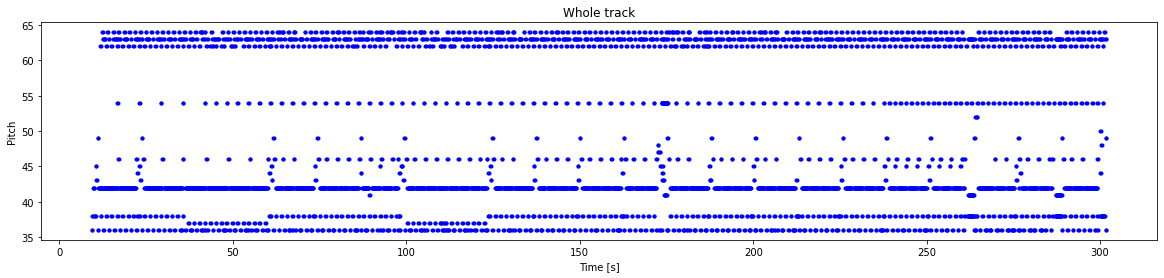

In [ ]:
# function that checks for correct song length and shows pianoroll for desired lengths
def plot_piano_roll(notes: pd.DataFrame, count: int):
  # check for correct max time
  if count>0 and count<=len(notes['pitch']):
    title = f'First {count} notes'
    plot_notes(notes,count, title)
  elif count == -1:
    title = f'Whole track'
    count = len(notes['pitch'])
    plot_notes(notes,count,title)
  else:
    title = f'First {count} notes'
    print('Error:',title)
    print('Notes count not in range')
    exit(1)

# function that plots pianoroll
def plot_notes(notes: pd.DataFrame, count: int, title: str):
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  notes['end'] = notes['start'] + notes['duration']
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

# execute funcition
plot_piano_roll(df, count=-1)


## 1.3 Processament de dades [1.5 pts]

Ara tornem a l'article i aplicarem el processament de dades. Buscar dins del fitxer *data_processing_functions.py* la funció que s'encarrega de dur a terme tot el processament de dades i trucar-la des d'aquí

In [ ]:
# execute all data processing
dpf.do_all_steps()

changing Tempo
histogramming
data/tempo/


/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


make song histo
File # 100 Current file =  data/histo// / ddb6a3db65461dca1a43de72f5375d8b.mid.pickle
shifting midi files
File # 100 Current file =  data/shifted/song_histo// / ddb6a3db65461dca1a43de72f5375d8b.mid.pickle
making note indexes
histogramming
data/shifted/tempo/
extracting chords
getting dictionary
converting chords to index sequences
done


1.3.1 Què fa la funció *change_tempo_folder*? Quina bpm fixa per a les cançons?

La funció change_tempo_folder bàsicament crea una còpia dels fitxers midi al directori data/tempo/ i en canvia el tempo fixant pbm a 500000 (per estandaritzar els tempos de les cançons). Pas a pas, agafa tots els fitxers del directori source_folder (en el nostre cas data/original/) i els copia al directori target_path (en el nostre cas data/tempo/). Un cop allà, crida a la funció change_tempo() on hi passa per paràmetre el nom del fitxer, el path original i el nou path. La funció change_tempo() està dins del fitxer midi_functions.py i el que fa es carregar el fitxer midi com a objecte MidiFile. Crea un nou objecte MidiFile buit i en copia els ticks_per_beat del fitxer passat per paràmetre. Llavors per cada track en el fitxer midi passat per paràmetre, en crea una còpia i en modifica el valor de msg. Si el tipus de msg és tempo fixa el bpm a 500000.

1.3.2 Un cop tenim executat el processament de dades s'hauran creat moltes carpetes i molts fitxers nous a l'actual carpeta ***data***. Ara farem servir alguns d'aquests fitxers per construir la figura 2 de l'article usant les dades processades. Crearem dues funcions:
* my_save_histo_oct_from_midi_folder
* my_midi_to_histo_oct

basades en les funcions ***save_histo_oct_from_midi_folder*** i ***midi_to_histo_oct*** que trobareu als fitxers ***midi_functions.py*** i ***data_processing_functions.py***. Ara les modificarem perquè ens tornin dades per a dos tipus d'histogrames: un igual a la figura 2 de l'article (aparicions VS pitch) i un altre, fent servir el *histo_oct*, que seran dades per pintar *aparicions VS notes en qualsevol octava*, és a dir, el nombre de vegades que apareix una nota (sense tenir en compte a què octava pertanyi) al llarg d'una cançó.

*indicació: És important entendre l'estructura de les variables:*
* pianoroll
* histo_bar
* histo_oct

*dins la funcio* ***midi_to_histo_oct***

In [62]:
#usa este vector como labels del segundo gráfico 
notas_en_una_octava = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

In [63]:
def my_save_histo_oct_from_midi_folder(tempo_folder,histo_folder):
    print(tempo_folder)
    nfiles=0
    for path, subdirs, files in os.walk(tempo_folder):
        for name in files:
            _path = path.replace('\\', '/') + '/'
            _name = name.replace('\\', '/')
            target_path = histo_folder+_path[len(tempo_folder):]
            if not os.path.exists(target_path):
                os.makedirs(target_path)
            try:
                nfiles+=1
                if nfiles%100==0:
                  print("File #",nfiles,"Current file = ",_path,"/",_name) 
                my_midi_to_histo_oct(samples_per_bar,octave, fs, _name, _path, target_path)
            except (ValueError, EOFError, IndexError, OSError, KeyError, ZeroDivisionError) as e:
                exception_str = 'Unexpected error in ' + name  + ':\n', e, sys.exc_info()[0]
                print(exception_str)

def my_midi_to_histo_oct(samples_per_bar,octave, fs, name, path, histo_path):
#    print(path + name)
    pianoroll = mf.get_pianoroll(name, path, fs)
    histo_bar = mf.pianoroll_to_histo_bar(pianoroll, samples_per_bar)
    # save histo_bar result to folder (with histobar in the name)
    pickle.dump(histo_bar,open(histo_path + name + '.histo_bar.pickle' , 'wb'))
    histo_oct = mf.histo_bar_to_histo_oct(histo_bar, octave)
    # save histo_oct result to folder
    pickle.dump(histo_oct,open(histo_path + name + '.pickle' , 'wb'))


In [102]:
# call function and save results to histo_folder1
my_save_histo_oct_from_midi_folder(tempo_folder1,histo_folder1)


data/tempo/


/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [103]:
# create empty DataFrame
total_df = pd.DataFrame()

# retrieve every file in histo folder
for path, subdirs, files in os.walk('/content/drive/MyDrive/PEC3_PAC3/data/histo/'):
  # for every file check
  for name in files:
    # if "histo" is in file name
    if 'histo' in name:
      target_path = '/content/drive/MyDrive/PEC3_PAC3/data/histo/'+name
      # load pickle file
      fig = pickle.load(open(target_path,'rb'))
      # add content to total_df dataframe
      total_df[name] = fig.tolist()


total_df.head()

,1b68452fdab1d72c285a4167a73dc042.mid.histo_bar.pickle,1bb161504426990565d84ccecb828c5b.mid.histo_bar.pickle,10288ea8e07b70c17f872fda82b94330.mid.histo_bar.pickle,1b9f5f325c2080d345d877f590aa3dbe.mid.histo_bar.pickle,1a0df14db4907570c68297595c5c8cf9.mid.histo_bar.pickle,1b5c44731913ee9117b58ecc6313fef7.mid.histo_bar.pickle,1b3d9bd0215ccd616b8d63dfca489298.mid.histo_bar.pickle,1a438ce2e05aa461f24f5f07dcca24a1.mid.histo_bar.pickle,1a9c75a2125eeab7ee574293f3b67762.mid.histo_bar.pickle,c24989559d170135b9c6546d1d2df20b.mid.histo_bar.pickle,...,1ab12f8b09b7fb40317676c428d3375a.mid.histo_bar.pickle,1b1377e88864ac1d2e598249751392ab.mid.histo_bar.pickle,1ae49af2dc6cdb068d749b464f330441.mid.histo_bar.pickle,b97c529ab9ef783a849b896816001748.mid.histo_bar.pickle,1b6451e48019f8560c88443c8f7a22ba.mid.histo_bar.pickle,1a1f147ae0d79631303f398d1ce59a9c.mid.histo_bar.pickle,1b21aa92341858ada59f72acd3d87a94.mid.histo_bar.pickle,1a95fbfafa2fcc5dec74406001126ad0.mid.histo_bar.pickle,05f21994c71a5f881e64f45c8d706165.mid.histo_bar.pickle,ddb6a3db65461dca1a43de72f5375d8b.mid.histo_bar.pickle
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

En aquest punt tenim un dataframe que hem de transposar i fer un join de totes les files, per comptar les courrències.

In [104]:
total_df = pd.DataFrame(total_df.T.sum())
total_df.columns = ['pitches']
total_df.head(10)

,pitches
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


En aquest punt tenim un DataFrame amb l'índex amb totes les tecles del teclat midi i una llista de totes les vegades que es toquen, que hem de reduir a ocurrències.

In [107]:
# convert to pandas for convenience
total_df = pd.DataFrame(total_df)
# sum all apearances
total_df['pitches'] = [sum(a) for a in total_df['pitches']]
# categorize the MIDI keys (12 times and then up to 128 keys)
total_df['majorMinor'] = (['Major','minor','Major','minor','Major','Major','minor','Major','minor','Major','minor','Major']*12)[:128]
total_df.head(10)

,pitches,majorMinor
0,0.0,Major
1,0.0,minor
2,0.0,Major
3,0.0,minor
4,0.0,Major
5,0.0,Major
6,0.0,minor
7,0.0,Major
8,0.0,minor
9,0.0,Major


En aquest punt tenim el df que volíem per graficar les vegades que s'ha tocat cada tecla.

<BarContainer object of 128 artists>

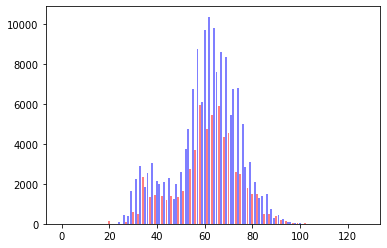

In [108]:
# plot
colors = ['red' if word == 'minor' else 'blue' for word in total_df.majorMinor]
plt.bar(x=total_df.index, height=total_df.pitches, color=colors, alpha=0.5)

Veiem en blau les vegades que es toquen les tecles de l'escala major i en vermell les vegades que es toquen les tecles sostingudes. Veiem que clarament es toquen més vegades les tecles no sostingudes que les sostingudes.

In [94]:
# create emty dataframe
total = pd.DataFrame()
# for every file in histo folder
for path, subdirs, files in os.walk('/content/drive/MyDrive/PEC3_PAC3/data/histo/'):
  # check if every file name
  for name in files:
    # if name does not have "histo" in it
      if 'histo' not in name:
        target_path = '/content/drive/MyDrive/PEC3_PAC3/data/histo/'+name
        # load file content
        fig = pickle.load(open(target_path,'rb'))
        # add content to dataframe
        total[name] = fig.tolist()

total

,1bb161504426990565d84ccecb828c5b.mid.pickle,1b68452fdab1d72c285a4167a73dc042.mid.pickle,10288ea8e07b70c17f872fda82b94330.mid.pickle,1b9f5f325c2080d345d877f590aa3dbe.mid.pickle,1a0df14db4907570c68297595c5c8cf9.mid.pickle,1b3d9bd0215ccd616b8d63dfca489298.mid.pickle,1b5c44731913ee9117b58ecc6313fef7.mid.pickle,1a438ce2e05aa461f24f5f07dcca24a1.mid.pickle,1a9c75a2125eeab7ee574293f3b67762.mid.pickle,5dd29e99ed7bd3cc0c5177a6e9de22ea.mid.pickle,...,1b1377e88864ac1d2e598249751392ab.mid.pickle,1a65205f15224a7e5c689176a44c2e32.mid.pickle,1ae49af2dc6cdb068d749b464f330441.mid.pickle,b97c529ab9ef783a849b896816001748.mid.pickle,1b6451e48019f8560c88443c8f7a22ba.mid.pickle,1a1f147ae0d79631303f398d1ce59a9c.mid.pickle,1b21aa92341858ada59f72acd3d87a94.mid.pickle,1a95fbfafa2fcc5dec74406001126ad0.mid.pickle,05f21994c71a5f881e64f45c8d706165.mid.pickle,ddb6a3db65461dca1a43de72f5375d8b.mid.pickle
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 2.0, 5.0, 4.0, 4.0, 2.0, 5.0, 4.0, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 3.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 8.0, 10.0, 6.0,...","[0.0, 0.0, 6.0, 7.0, 6.0, 7.0, 6.0, 7.0, 6.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 17.0, 2.0, 0.0,...","[0.0, 1.0, 3.0, 3.0, 5.0, 10.0, 3.0, 3.0, 5.0,...",...,"[0.0, 5.0, 5.0, 5.0, 0.0, 10.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 2.0, 9.0, 0.0, 1.0, 2.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 1.0, 9.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 7.0, 3.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 8.0, ...","[0.0, 0.0, 4.0, 5.0, 3.0, 10.0, 2.0, 1.0, 0.0,...","[0.0, 0.0, 2.0, 5.0, 4.0, 4.0, 2.0, 5.0, 4.0, ...","[0.0, 2.0, 5.0, 4.0, 4.0, 2.0, 5.0, 4.0, 4.0, ..."
1,"[0.0, 0.0, 8.0, 8.0, 0.0, 0.0, 2.0, 13.0, 1.0,...","[0.0, 2.0, 2.0, 2.0, 0.0, 2.0, 10.0, 3.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 2.0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 5.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 8.0, 1.0, 0.0, 2.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 3.0, 2.0, 2.0, 2.0, 3.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 4.0, 4.0, 0.0, 0.0, 0.0, 4.0, 2.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 8.0, 3.0, 0.0, 4.0, 6.0, ...","[0.0, 0.0, 2.0, 16.0, 16.0, 16.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 8.0, 7.0, 8.0, 8.0, 21.0, 1.0, 1.0, 4.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 3.0, 0.0, 0.0, 2.0, 5.0, 2.0, 0.0, 1.0, ...","[0.0, 9.0, 10.0, 19.0, 16.0, 14.0, 4.0, 7.0, 3...","[4.0, 0.0, 4.0, 0.0, 4.0, 0.0, 4.0, 0.0, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 8.0, 1.0, 2.0, ...","[0.0, 0.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, ...","[0.0, 2.0, 12.0, 14.0, 4.0, 0.0, 0.0, 0.0, 2.0...","[0.0, 0.0, 0.0, 3.0, 0.0, 10.0, 0.0, 3.0, 0.0,...",...,"[0.0, 5.0, 5.0, 5.0, 8.0, 8.0, 1.0, 8.0, 12.0,...","[0.0, 2.0, 11.0, 12.0, 12.0, 0.0, 11.0, 13.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 15.0, 2.0, 15.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.0, 15.0, 13.0, 6.0, 0.0, 7.0, 22.0, 16.0, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 8.0, 8.0, 2.0, ...","[0.0, 0.0, 2.0, 2.0, 2.0, 19.0, 6.0, 6.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.

En aquest punt per cadascuna de les 12 notes tenim una llista per acord i cançó de les vegades que apareix (sense tenir en compte de quina octava és)

In [95]:
# transpose dataframe
total = total.T
# rename columns
total.columns = notas_en_una_octava
# summ all values vor each note
total = total.sum()
total.head(10)

C     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
C#    [0.0, 0.0, 8.0, 8.0, 0.0, 0.0, 2.0, 13.0, 1.0,...
D     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
D#    [0.0, 4.0, 4.0, 0.0, 0.0, 4.0, 12.0, 1.0, 4.0,...
E     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
F     [0.0, 4.0, 4.0, 0.0, 0.0, 4.0, 3.0, 8.0, 4.0, ...
F#    [0.0, 9.0, 6.0, 16.0, 4.0, 9.0, 4.0, 0.0, 3.0,...
G     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
G#    [0.0, 2.0, 10.0, 0.0, 0.0, 8.0, 13.0, 8.0, 6.0...
A     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
dtype: object

En aquest punt tenim en una sola llista per nota les vegades que s'ha tocat en totes les cançons.

In [96]:
# convert to pandas for convenience
total = pd.DataFrame(total)
# sum all appearances fo the notes
total[0] = [sum(a) for a in total[0]]

Text(0, 0.5, 'count')

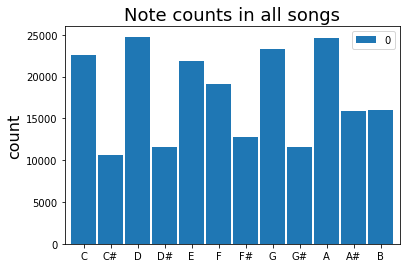

In [101]:
# plot histogram of note counts for all songs
ax = total.plot.bar(rot=0, width=0.9)
ax.set_title('Note counts in all songs', fontsize=18)
ax.set_ylabel('count', fontsize=16)

1.3.3 Buscar a internet sobre les escales musicals i indicar quina escala és la que més apareix a totes les cançons analitzades. Quines diries que són les notes més importants de l'escala?

Les escales principals musicals venen definides per les notes utilitzades. A grans trets, podem diferenciar dos tipus d'escales, les que no fan servir bemolls ni sostinguts i les que en fan servir. L'escala major i menor natural contenen les mateixes notes i no en tenen cap de sostinguda. Per tant, les dues contenen C,D,E,F,G,A i B. La resta d'escales en algun moment contenen un sostingut (#). Si observem el darrer histograma de les aparicions de les notes en totes les cançons (sense tenir en compte a quina octava estan), veiem clarament que l'escala major o menor natural són les més utilitzades, ja que les vegades que apareixen les seves notes són molt superiors a qualsevo altra nota sostinguda. Dintre de l'escala major (o la menor natural), observem que la nota més utilitzada és el RE (D), seguida del LA (A), DO (C), SOL(G) i MI(E), i que clarament la nota menys utilitzada de l'escala és el FA (F). De fet, això també és lògic ja que les notes més utilitzades també formen part d'escales menors, mentre que el FA (F) no apareix a gaires escales més (per exemple les pentatòniques menors i majors estan compostes de A, C, D, E, G (no hi ha ni B ni F). No es pot dir pròpiament que s'utilitzen més les escales majors o menors naturals només comptant ús de notes, ja que hi ha notes no sostingudes que apareixen en escales menors. El que sí que podem afirmar és  que les notes no sostingudes són utilitzades més que les sostingudes.

#2. LSTM per a acords [5 pts]

El pas següent a l'article és l'entrenament d'una xarxa LSTM per generar acords. Aquesta part la farem amb un data set més petit i ho compararem amb resultats d'entrenaments previs que us facilitarem. Primer carreguem les llibreries que necessitarem

In [111]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Activation
from keras.layers import Embedding
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import keras.utils
from keras.utils import np_utils
from random import shuffle
import progressbar
import time

## 2.1 Càrrega de dades [0.5 pts]

2.1.1 A la carpeta ***data*** trobareu un fitxer anomenat ***dataset.pkl*** que conté 11338 cançons de train i 3780 de test. Usant *pickle* carregar les dades i després separar 2000 per *train* i 500 cançons per *test* a les variables:
* train_set
* test_set

crea a més *train_set_size* i *test_set_size*

In [112]:
# open dataset file and load into data variable
with open('/content/drive/MyDrive/PEC3_PAC3/data/dataset.pkl', 'rb') as f:
    data = pickle.load(f)

# convert data into numpy array
df = np.asarray(data)

# define train_set_size and test_set_size
train_set_size = 2000
test_set_size = 500

# shuffle de dataset
shuffle(df)

# extract tran and test set
train_set = np.array([np.array(xi) for xi in df[0][:train_set_size]])
test_set = np.array([np.array(xi) for xi in df[1][:test_set_size]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when

## 2.2 Model amb una capa de ***Embedding*** [0.5 pts]

2.2.1 Ara definirem els paràmetres de la nostra xarxa LSTM usant els paràmetres que donen a l'article. L'únic canvi serà en la mida de la xarxa LSTM, en què farem servir la meitat de la LSTM de l'article i nombre d'epochs que farem servir 10 en el nostre cas

In [113]:
batch_size = 1
step_size = 1
epochs = 10

#according to the article the LSTM size was optimum at 256, so we get 128
lstm_size = 128
learning_rate = 1e-05
optimizer = 'Adam'

El codi següent és per mantenir l'estructura de carpetes que usen a l'article, ja que hi ha molt codi que depèn d'aquesta estructura:

In [114]:
##--------NO TOCAR-------------------------------------------------------
base_path = 'models/chords/'
model_filetype = '.pickle'

shuffle_train_set = True
bidirectional = False

#Create model dir
fd = {'shifted': shifted, 'lr': learning_rate, 'emdim': chord_embedding_dim, 'opt': optimizer,
'bi': bidirectional, 'lstms': lstm_size, 'trainsize': train_set_size, 'testsize': test_set_size, 'samples_per_bar': samples_per_bar}
t = str(np.random.randint(1000,9999))
model_name = t+ '-Shifted_%(shifted)s_Lr_%(lr)s_EmDim_%(emdim)s_opt_%(opt)s_bi_%(bi)s_lstmsize_%(lstms)s_trainsize_%(trainsize)s_testsize_%(testsize)s_samples_per_bar%(samples_per_bar)s' % fd
model_path = base_path + model_name + '/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
##--------NO TOCAR-------------------------------------------------------


2.2.2 Finalment definim i compilem la xarxa amb una capa d'Embedding abans de la LSTM. Per aquest pas, accedir al codi original de l'article i cercar en quin fitxer s'entrena la LSTM copiar l'estructura eliminant codi que no és del nostre interès

In [115]:
verbose = False
show_plot = False
save_plot = True
save_step = 10
shuffle_train_set = True
bidirectional = False

print('creating model...')
model = Sequential()
model.add(Embedding(num_chords, chord_embedding_dim, input_length=step_size, name="embedding", batch_input_shape=(batch_size,step_size)))

# create model
model.add(LSTM(lstm_size, stateful=True))
model.add(Dense(num_chords))
model.add(Activation('softmax'))
if optimizer == 'Adam':
    optimizer = Adam(lr=learning_rate)
elif optimizer == 'RMS':
    optimizer = RMSprop(lr=learning_rate)
loss = 'categorical_crossentropy'
print("compiling model")
model.compile(optimizer, loss)


creating model...
compiling model


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## 2.3 Entrenament [2 pts]

2.3.1 Seguint el codi original de l'article on es defineix l'arquitectura de la LSTM per als acords, hi ha 3 funcions més:
* test()
* train()
* save_params()

que ens ajudaran per a l'entrenament, testeig i per guardar les dades sobre el model entrenat. Guardarem el valor de la ***loss*** tant per a test com per a train cada 500 cançons, per la qual cosa tindrem més d'un punt per epoch. Modifica, si cal, les funcions *test()* i *train()* perquè els fitxers de *total_test* i *total_train* deixin constància de l'epoch a què pertanyen, això t'ajudarà a pintar les dades més endavant.

***Afegeix, abans de cada funció una capçalera explicant breument allò que aquesta fa.***

---

*nota: comprova que has definit totes les variables necessàries perquè les* *funcions no donin error al mig de l'entrenament. Comença usant menys dades* *per agilitzar el procés i un cop funcioni tot utilitza el set complet*

In [ ]:
# initialize variables
epoch_array=[]
total_test_loss_array = [] 
total_train_loss_array = []
total_epoch_array = []
total_test_loss = 0
show_plot = False
save_plot = False
test_step = 500
verbose = False
save_step = 1
epoch_num = 1

# function to test data
def test():
    print('\nTesting:')
    total_test_loss = 0
    total_test_epoch = 0

    bar = progressbar.ProgressBar(maxval=test_set_size, redirect_stdout=False)
    for i, test_song in enumerate(test_set):
        X_test = test_song[:-1]
        Y_test = np_utils.to_categorical(test_song[1:], num_classes=num_chords)
        loss = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=verbose)
        model.reset_states()
        total_test_loss += loss
        bar.update(i+1)
    total_test_loss_array.append(total_test_loss/test_set_size)
    print('\nTotal test loss: ', total_test_loss/test_set_size)
    print('-'*50)
    plt.plot(total_test_loss_array, 'b-', label='test loss')
    plt.plot(total_train_loss_array, 'r-', label='train loss')
#    plt.legend()
    plt.ylabel(model_path)
#    plt.axis([0, 50, 3, 5])
    plt.grid()
    if show_plot: plt.show()
    if save_plot: plt.savefig(model_path+'plot.png')
    pickle.dump((total_epoch_array,total_test_loss_array),open(model_path+'total_test_loss_array.pickle', 'wb'))
    pickle.dump((total_epoch_array,total_train_loss_array),open(model_path+'total_train_loss_array.pickle', 'wb'))

# function to train data: for each epoch, if shuffle is activated, shuffle the set. Then for every song  in the train set
def train():
    print('training model...')
    total_train_loss = 0
    for e in range(1, epochs+1):
        print('Epoch ', e, 'of ', epochs, 'Epochs\nTraining:')
        if shuffle_train_set:
            shuffle(train_set)
        bar = progressbar.ProgressBar(maxval=train_set_size)
        for i, song in enumerate(train_set):
            # bar.start()
            X = song[:-1]
            Y = np_utils.to_categorical(song[1:], num_classes=num_chords)
            hist = model.fit(X, Y, batch_size=batch_size, shuffle=False, verbose=verbose)
            model.reset_states()
            bar.update(i+1)
#            print(hist.history)
            total_train_loss += hist.history['loss'][0]
            if (i+1)%test_step is 0:
                total_train_loss = total_train_loss/test_step
                total_train_loss_array.append(total_train_loss)
                total_epoch_array.append((e-1) + 1/(len(train_set)/(i+1)))
                test()
                total_train_loss = 0
    
        if e%save_step is 0:
            print('saving model')
            model_save_path = model_path + 'model_' + 'Epoch' + str(e) + '_' + str(i+1) + model_filetype
            model.save(model_save_path)

def save_params():
    with open(model_path + 'params.txt', "w") as text_file:
        text_file.write("epochs: %s" % epochs + '\n')
        text_file.write("train_set_size: %s" % train_set_size + '\n')
        text_file.write("test_set_size: %s" % test_set_size + '\n')
        text_file.write("lstm_size: %s" % lstm_size + '\n')
        text_file.write("embedding_dim: %s" % chord_embedding_dim + '\n')
        text_file.write("learning_rate: %s" % learning_rate + '\n')
        #text_file.write("save_step: %s" % save_step + '\n')
        text_file.write("shuffle_train_set: %s" % shuffle_train_set + '\n')
        text_file.write("test_step: %s" % test_step + '\n')
        text_file.write("bidirectional: %s" % bidirectional + '\n')
        text_file.write("num_chords: %s" % num_chords + '\n')
        text_file.write("chord_n: %s" % chord_n + '\n')


2.3.2 Respon les preguntes següents:
* Què representa cada element de *X* a la funció de *train()*?
* Què s'està usant com a *label* per a cada element de *X*?
* Justifica l'ús de *categorical_crossentropy* com a funció de *loss*
* Què creus que està aprenent la xarxa?

Cada element de X representa l'acord (l'índex de l'acord) que s'està tocant en aquell punt de la cançó. L'etiqueta Y que s'usa per a cada element de X són els acords que segueixen a l'element de X, categoritzats. Justament s'utilitza el categorical_crossentropy perque la label Y està categoritzada. Aquesta és una funció de pèrdua que s'utilitza en tasques de classificació multiclasse. Són tasques on un exemple només pot pertànyer a una de les moltes categories possibles, i el model ha de decidir quina. La xarxa està aprenent quins acords van junts en una cançó, és a dir, que si jo toco un acord, quin acord és harmoniós amb l'acord que estic tocant i possiblement ve a continuació.

2.3.3 Entrena la xarxa usant les funcions anteriors

saving params
starting training..
training model...
Epoch  1 of  10 Epochs
Training:


 25% (500 of 2000) |#####                | Elapsed Time: 0:03:20 ETA:   0:10:00


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:52 ETA:  00:00:00


Total test loss:  3.233249479293823
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:49 ETA:  00:00:00


Total test loss:  3.1543264746665955
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:47 ETA:  00:00:00


Total test loss:  3.12336864900589
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:48 ETA:  00:00:00


Total test loss:  3.1035869212150575
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch1_2000.pickle/assets


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch1_2000.pickle/assets


Epoch  2 of  10 Epochs
Training:


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:02:00 ETA:  00:00:00


Total test loss:  3.076696541547775
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


 50% (1001 of 2000) |#######       | Elapsed Time: 0:10:37 ETA:  1 day, 6:40:38


Total test loss:  3.082331568479538
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:49 ETA:  00:00:00


Total test loss:  3.062399036645889
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:56 ETA:  00:00:00


Total test loss:  3.030930241107941
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch2_2000.pickle/assets


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch2_2000.pickle/assets


Epoch  3 of  10 Epochs
Training:


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:50 ETA:  00:00:00


Total test loss:  3.0474661452770233
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:49 ETA:  00:00:00


Total test loss:  3.0314730112552644
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:46 ETA:  00:00:00


Total test loss:  3.008310453891754
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:47 ETA:  00:00:00


Total test loss:  3.005577706813812
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch3_2000.pickle/assets


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch3_2000.pickle/assets


Epoch  4 of  10 Epochs
Training:


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:47 ETA:  00:00:00


Total test loss:  2.9977957298755644
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:49 ETA:  00:00:00


Total test loss:  2.9871156265735626
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:48 ETA:  00:00:00


Total test loss:  2.979906713247299
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:51 ETA:  00:00:00


Total test loss:  2.9797512249946596
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch4_2000.pickle/assets


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch4_2000.pickle/assets


Epoch  5 of  10 Epochs
Training:


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:50 ETA:  00:00:00


Total test loss:  2.971455838918686
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:52 ETA:  00:00:00


Total test loss:  2.969511302471161
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:51 ETA:  00:00:00


Total test loss:  2.956377203822136
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:48 ETA:  00:00:00


Total test loss:  2.964386269211769
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch5_2000.pickle/assets


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch5_2000.pickle/assets


Epoch  6 of  10 Epochs
Training:


 25% (500 of 2000) |#####                | Elapsed Time: 0:03:14 ETA:   0:09:30


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:45 ETA:  00:00:00


Total test loss:  2.953805909991264
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:52 ETA:  00:00:00


Total test loss:  2.948293955206871
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:48 ETA:  00:00:00


Total test loss:  2.9521341361999514
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:48 ETA:  00:00:00


Total test loss:  2.9471417607069017
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch6_2000.pickle/assets


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch6_2000.pickle/assets


Epoch  7 of  10 Epochs
Training:


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:48 ETA:  00:00:00


Total test loss:  2.9503915404081344
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:47 ETA:  00:00:00


Total test loss:  2.9489171934127807
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:47 ETA:  00:00:00


Total test loss:  2.942020431637764
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:50 ETA:  00:00:00


Total test loss:  2.9267660211324693
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch7_2000.pickle/assets


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch7_2000.pickle/assets


Epoch  8 of  10 Epochs
Training:


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:54 ETA:  00:00:00


Total test loss:  2.9234907075166703
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:51 ETA:  00:00:00


Total test loss:  2.932391506433487
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:49 ETA:  00:00:00


Total test loss:  2.930610726356506
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:02:00 ETA:  00:00:00


Total test loss:  2.9280069974660874
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch8_2000.pickle/assets


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch8_2000.pickle/assets


Epoch  9 of  10 Epochs
Training:


 25% (500 of 2000) |#####                | Elapsed Time: 0:03:10 ETA:   0:08:46


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:51 ETA:  00:00:00


Total test loss:  2.927582064270973
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:50 ETA:  00:00:00


Total test loss:  2.9309169833660125
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:53 ETA:  00:00:00


Total test loss:  2.920169760465622
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:02:00 ETA:  00:00:00


Total test loss:  2.9230601667165756
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch9_2000.pickle/assets


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch9_2000.pickle/assets


Epoch  10 of  10 Epochs
Training:


 25% (500 of 2000) |#####                | Elapsed Time: 0:03:21 ETA:   0:13:03


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:57 ETA:  00:00:00


Total test loss:  2.9176616706848146
--------------------------------------------------


N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:58 ETA:  00:00:00


Total test loss:  2.9303549563884737
--------------------------------------------------


 75% (1500 of 2000) |###############     | Elapsed Time: 0:14:05 ETA:   0:02:18


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:57 ETA:  00:00:00


Total test loss:  2.917992992401123
--------------------------------------------------


100% (2000 of 2000) |####################| Elapsed Time: 0:19:31 ETA:  00:00:00


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:01:59 ETA:  00:00:00


Total test loss:  2.9155037971735003
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch10_2000.pickle/assets


INFO:tensorflow:Assets written to: models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch10_2000.pickle/assets


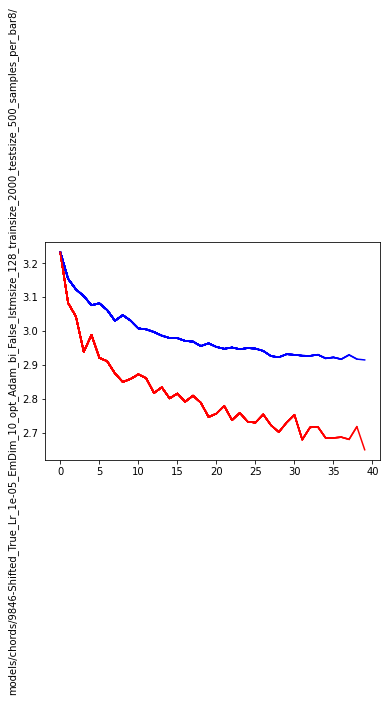

In [ ]:
# save parameters
print("saving params")
save_params()
# train model
print("starting training..")
train()

En aquest punt hem entrenat el model amb els paràmetres especificats. El model ha tardat aproximadament dues hores a entrenar-se completament. Veiem que el train loss (en vermell) ha anat baixant fins assolir el valor aproximat de 2.6, aparentment sense sobreentrenament, ja que el valor del loss, tot i que hi ha pics, no té cap mínim i en cap moment sembla que vulgui pujar. Veiem també que el test loss s'ha quedat en aproximadament 2.9, un valor major que pel train loss, que és normal (és normal que el test predigui una mica pitjor que el train).

##2.4 Comparació de models [2 pts]

En aquest darrer pas compararem diferents models. A la carpeta *models/chords* trobaràs les dades (en un format similar al generat anteriorment) de l'entrenament de models similars amb altres paràmetres:

1. carpeta: 2717-Shifted_True_...
2. carpeta: 5102-Shifted_True_...

2.4.1 Compara els 3 models: pintar les funcions de loss per a train i test de cada model.

* Indica els paràmetres de cadascun dels 3 models (el que heu entrenat i els 2 que us hem donat)
* Quin set de paràmetres ha donat la millor performance?
* S'aprecia overfitting en algun dels models? Justifica la teva resposta

In [ ]:
# load model settings
my9846 = pd.read_csv('/content/drive/MyDrive/PEC3_PAC3/models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/params.txt', sep=":", header = None, engine='python')
upc2717 = pd.read_csv('/content/drive/MyDrive/PEC3_PAC3/models/chords/2717-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_2000_testsize_500_samples_per_bar8/params_0.txt', sep=":", header = None, engine='python')
upc5102 = pd.read_csv('/content/drive/MyDrive/PEC3_PAC3/models/chords/5102-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_4000_testsize_1000_samples_per_bar8/params_0.txt', sep=":", header = None, engine='python')

# rename columns
my9846.columns = ['setting', '9846']
upc2717.columns = ['setting', '2717']
upc5102.columns = ['setting', '5102']

# joins model setting to compare
results = my9846.join(upc2717['2717']).join(upc5102['5102']).set_index(['setting'])
results

,9846,2717,5102
setting,,,
epochs,10,10,20
train_set_size,2000,2000,4000
test_set_size,500,500,1000
lstm_size,128,256,256
embedding_dim,10,10,10
learning_rate,1e-05,1e-05,1e-05
shuffle_train_set,True,True,True
test_step,500,500,1000
bidirectional,False,False,False


Observem que el model 5102 s'ha entrenat amb 4000 cançons, mentre que els altres dos només amb 2000. Igualment, el model 5102 ha estat testejat amb 1000 cançons mentre que els altres dos amb 500. El nostre model (9846) ha estat entrenat amb 128 capes de lst mentre que els altres dos amb 256. Finalment, el test_step, en el model 5102 és de 1000 i en els altres dos de 500 (és proporcional en tots tres models).

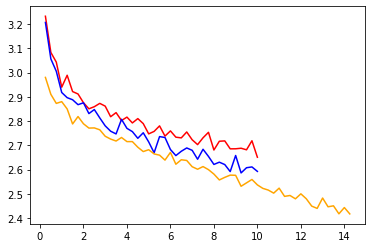

In [ ]:
# load total tran losses for each model
total_train_loss_9846 = pickle.load(open('/content/drive/MyDrive/PEC3_PAC3/models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/total_train_loss_array.pickle','rb'))
total_train_loss_2717 = pickle.load(open('/content/drive/MyDrive/PEC3_PAC3/models/chords/2717-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_2000_testsize_500_samples_per_bar8/total_train_loss_array.pickle','rb'))
total_train_loss_5102 = pickle.load(open('/content/drive/MyDrive/PEC3_PAC3/models/chords/5102-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_4000_testsize_1000_samples_per_bar8/total_train_loss_array.pickle','rb'))

# correct epochs from 2717 model
total_train_loss_2717 = ([0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0],total_train_loss_2717[1])

# plot results
plt.plot(total_train_loss_9846[0],total_train_loss_9846[1], c='red')
plt.plot(total_train_loss_2717[0],total_train_loss_2717[1], c='blue')
plt.plot(total_train_loss_5102[0],total_train_loss_5102[1], c='orange')

Veiem que el model entrenat amb millor loss al final de l'entrenament és el 5102. Això és lògic perque el model s'ha entrenat amb el doble de cançons que en el model 2717, i respecte al model 9846 (el d'aquesta pràctica) no només amb el doble de cançons sinó amb el doble de capes de lstm. A més sembla que el loss del model 5102 baixa de manera més homogènia, sense tants pics com ens els models 2717 i 9846.

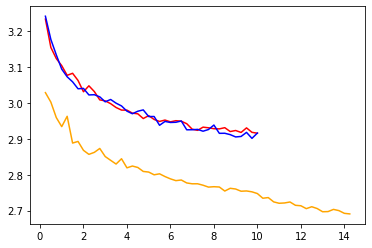

In [ ]:
# load total test losses for each model
total_test_loss_9846 = pickle.load(open('/content/drive/MyDrive/PEC3_PAC3/models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/total_test_loss_array.pickle','rb'))
total_test_loss_2717 = pickle.load(open('/content/drive/MyDrive/PEC3_PAC3/models/chords/2717-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_2000_testsize_500_samples_per_bar8/total_test_loss_array.pickle','rb'))
total_test_loss_5102 = pickle.load(open('/content/drive/MyDrive/PEC3_PAC3/models/chords/5102-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_4000_testsize_1000_samples_per_bar8/total_test_loss_array.pickle','rb'),encoding='latin-1')

# correct epochs from model 2171
total_test_loss_2717 = ([0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0],total_test_loss_2717[1])

# plot values
plt.plot(total_test_loss_9846[0],total_test_loss_9846[1], c='red')
plt.plot(total_test_loss_2717[0],total_test_loss_2717[1], c='blue')
plt.plot(total_test_loss_5102[0],total_test_loss_5102[1], c='orange')

Observem que el loss del test set del model 5102 te el valor mínim dels tres models, tant en el test com en el train. Però és en el test on veiem que el model 5102 es diferencia més respecte als altres dos models, assolint un loss de menys de 2.7.
No observem overfitting en cap dels tres models. Amb un model amb overfitting, la gràfica del loss va baixant però arriba un moment que remonta. Generalment també podem veure que la performance del train set va millorant i en canvi la del test set empitjora, i això no passa en cap dels tres casos.

# 3 Anàlisi de la capa d'embedding [2 pts]

En aquesta secció recrearem la figura 8 de l'article amb la xarxa que hem entrenat i la que millor performance ens ha donat a la comparació.

In [9]:
from keras.models import load_model
import keras
from keras import backend as K

## 3.1 Càrrega de models entrenats i generació d'embeddings [1 pts]

3.1.1 Utilitza el *load_model* de **keras** per carregar:
* el model que hem entrenat: *my_model*
* el model amb millor performance: *bp_model*

In [10]:
# load original models
my_model = load_model('/content/drive/MyDrive/PEC3_PAC3/models/chords/9846-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch10_2000.pickle/')
bp_model = load_model('/content/drive/MyDrive/PEC3_PAC3/models/chords/5102-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_4000_testsize_1000_samples_per_bar8/model_Epoch14_4000.pickle/')

3.1.2 Ara crearem, per a cada model, un nou model per als embeddings. Per fer això, hauràs de crear un model l'entrada del qual sigui igual a l'entrada dels models originals i la sortida sigui el layer embedding. Això ho pots fer usant la funció *get_layer()* del model.

In [11]:
# get embedding layer from each model
my_model_embedding = my_model.get_layer('embedding')
bp_model_embedding = bp_model.get_layer('embedding')

3.1.3 El model d'embedding rep un acord i torna un vector de 10 dimensions amb l'embedding per a cada acord. Calculeu aquests vectors amb cadascun dels models d'embedding

In [12]:
# retrieve vectors via prediction, and store them into my_prediction array
my_prediction = []
for i in range (0,50):
  my_prediction.append(my_model_embedding(i))

# another way to get the vectors is through the function get_weights()
bp_prediction = bp_model_embedding.get_weights()


3.1.4 Aplica un squeeze per eliminar els eixos de dimensió 1. El resultat d'aquest squeeze hauria de ser (50,10)

In [13]:
# apply squeeze to the vectors
my_model_vector = np.squeeze(my_prediction)
bp_model_vector = np.squeeze(bp_prediction)
print('my_model_vector shape: ',my_model_vector.shape)
print('bp_model_vector shape: ',bp_model_vector.shape)

my_model_vector shape:  (50, 10)
bp_model_vector shape:  (50, 10)


## 3.2 Anàlisi PCA [1 pts]

Per acabar amb la nostra anàlisi dels embeddings, farem un procés de PCA per reduir les dimensions dels vectors resultants i poder pintar-los en 2D.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

3.2.1 Escalar els vectors i aplicar PCA per reduir a 2 les dimensions

In [15]:
# Standarize and apply PCA to my_model vectors
pca_my_model = PCA(n_components=2)
x_my_std = StandardScaler().fit_transform(my_model_vector)
my_model_components = pca_my_model.fit_transform(x_my_std)

# Standarize and apply PCA to bp_model vectors
pca_bp_model = PCA(n_components=2)
x_bp_std = StandardScaler().fit_transform(bp_model_vector)
bp_model_components = pca_bp_model.fit_transform(x_bp_std)

3.2.2 Pintar per a tots dos embeddings els vectors en un scatterplot. Afegeix anotacions amb les notes de l'acord i comenta el resultat: Observes l'efecte word2vect a les gràfiques?

Fes servir aquesta funció per obtenir un índex per als acords i les seves notes

In [16]:
def get_chord_dict():
    chord_to_index = pickle.load(open(dict_path + chord_dict_name, 'rb'))
    index_to_chord = pickle.load(open(dict_path + index_dict_name, 'rb'))
    return chord_to_index, index_to_chord

chord_to_index, idx_2_chord = get_chord_dict()

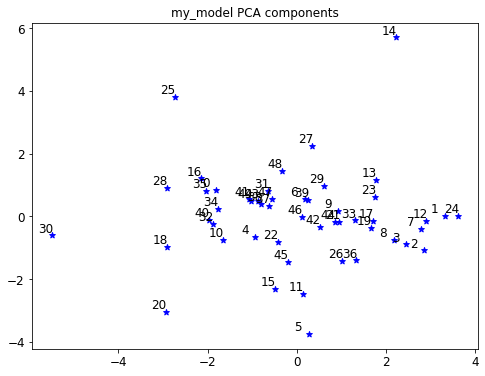

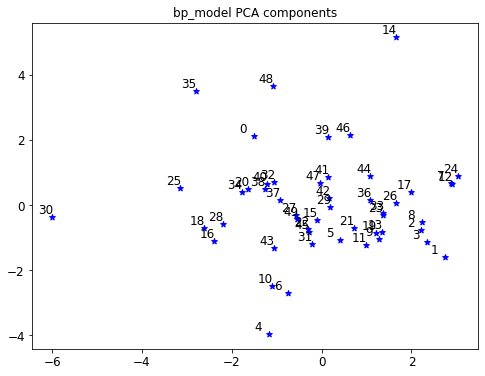

In [17]:
def get_chord_dict():
    chord_to_index = pickle.load(open(dict_path + chord_dict_name, 'rb'))
    index_to_chord = pickle.load(open(dict_path + index_dict_name, 'rb'))
    return chord_to_index, index_to_chord

chord_to_index, idx_2_chord = get_chord_dict()

# function to plot pca results
def plot_pca(chords,title):
  
  fig, ax = plt.subplots()
  fig.set_size_inches(8, 6)
  ax.set_title(title)

  plt.tick_params(labelsize=12)
  
  style = dict(size=12, color='black')

  for i in range(0,len(idx_2_chord)):
    try:
      ax.text(-chords[i,0]-0.32,chords[i,1]+0.11, chord_to_index[idx_2_chord[i]],**style)
      ax.scatter(-chords[i,0],chords[i,1], c="blue", marker="*")
      
    except:
      pass

  plt.show()

# plot my_model PCA components
plot_pca(my_model_components,'my_model PCA components')
# plot bp_model PCA components
plot_pca(bp_model_components,'bp_model PCA components')

L'efecte Word2vec el podem veure observant que un cop tenim les dimensions reduïdes, veiem agrupacions d'acords, és a dir, acords que estan més propers els uns als altres i que, per tant, podem dir que són similars, o que almenys es té tendència a tocar junts a les cançons. Observem en canvi acords que queden allunyats de qualsevol grup, que podrien ser acords reslment estranys de trobar en alguna cançó.

3.2.3 Crea una funció per calcular totes les distàncies entre els primers 20 acords. Després fes una llista amb les 10 distàncies mínimes per a tots dos models. Estan relacionats aquests acords amb distàncies mínimes?

In [20]:
# function to calculate distances
def distance (vector, to_range=20):

  # set coordinates x and y
  x = np.array([pt[0] for pt in vector[:to_range]])
  y = np.array([pt[1] for pt in vector[:to_range]])

  # calculate distance matrix
  dist_matrix = np.sqrt(np.square(x - x.reshape(-1,1)) + np.square(y - y.reshape(-1,1)))

  # keep only upper triangular part of the matrix, to avoid duplicates
  dist_matrix = np.triu(dist_matrix)

  # convert distance matrix to pandas for convenience
  dist_matrix = pd.DataFrame(dist_matrix)

  # substitute 0 for nan
  dist_matrix.replace(0, np.nan, inplace=True)

  # initialize array of distances
  min_dist_pairs = dist_matrix.stack().sort_values().reset_index().iloc[:, [2,0,1]].values.tolist()

  return pd.DataFrame(min_dist_pairs)

print("10 min distances of my_model:")
distance(my_model_vector).head(10)

10 min distances of my_model:


,0,1,2
0,0.027744,10.0,17.0
1,0.050455,3.0,6.0
2,0.058953,4.0,8.0
3,0.059094,10.0,11.0
4,0.069739,12.0,17.0
5,0.077597,9.0,13.0
6,0.078141,10.0,12.0
7,0.083537,11.0,17.0
8,0.091446,4.0,13.0
9,0.100075,13.0,19.0


De la llista del nostre model sembla que l'acord 10 té acords molt propers (el 17, el 11 i el 12). Així mateix l'acord 17 també té tres acords molt propers (el 10, el 12 i el 11) i es podria arribar a deduir que els acords 10,11,12 i 17 formen un grup d'acords molt similars.

In [21]:
print("10 min distances of bp_model:")
distance(bp_model_vector).head(10)

10 min distances of bp_model:


,0,1,2
0,0.049754,7.0,12.0
1,0.054710,17.0,19.0
2,0.057265,3.0,6.0
3,0.077038,0.0,11.0
4,0.091424,8.0,12.0
5,0.135682,7.0,8.0
6,0.166862,15.0,16.0
7,0.167675,3.0,4.0
8,0.168775,9.0,10.0
9,0.170501,1.0,10.0


En el model entrenat obsrevem que aquestes relacions canvien i per bé que hi ha acords amb algunes parelles amb distància mínima, no es detecten un grup de 4 acords com en el nostre model entrenat.

#4. Roda de 5tes (Bonus Track) [0.5 pts]

En aquest bonus track, i usant el mateix que has fet servir per als apartats anteriors, podràs dibuixar la roda de cinquenes amb dades entrenades sobre la mateixa base de dades, però no fer el shifteig dels acords.

Fes servir les dades que trobaràs a la carpeta *models/chords/9671-Shifted_False...* per repetir el procés de l'anàlisi de PCA

un cop tens els vectors, utilitza les següents funcions per dibuixar la roda de cinquenes

In [22]:
def get_chord_dict_no_shifted():
    chord_to_index = pickle.load(open('data/chord_dict.pickle', 'rb'))
    index_to_chord = pickle.load(open('data/index_dict.pickle', 'rb'))
    return chord_to_index, index_to_chord

chord_to_index_, idx_2_chord_ = get_chord_dict_no_shifted()

In [23]:
ddd={tuple((0,4,7)):'C',
tuple((1,5,8)):'C#',
tuple((2,6,9)):'D',
tuple((3,7,10)):'D#',
tuple((4,8,11)):'E',
tuple((0,5,9)):'F',
tuple((1,6,10)):'F#',
tuple((2,7,11)):'G',
tuple((0,3,8)):'G#',
tuple((1,4,9)):'A',
tuple((2,5,10)):'A#',
tuple((3,6,11)):'B'}


def plot_5th_circle(X_chords_2d):
  
  fig, ax = plt.subplots()
  fig.set_size_inches(8, 6)

  plt.tick_params(labelsize=12)
  
  style = dict(size=12, color='black')

  for i in range(0,len(idx_2_chord_)):
    try:
      ax.text(-X_chords_2d[i,0]-0.32,X_chords_2d[i,1]+0.11, ddd[idx_2_chord_[i]],**style)
      ax.scatter(-X_chords_2d[i,0],X_chords_2d[i,1], c="blue", marker="*")
      
    except:
      pass

  plt.show()

In [24]:
# load model
ns_model = load_model('/content/drive/MyDrive/PEC3_PAC3/models/chords/9671-Shifted_False_Lr_1.5e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_4000_testsize_1000_samples_per_bar8/model_Epoch8_4000.pickle/')

In [25]:
# get embedding layer
ns_model_embedding = ns_model.get_layer('embedding')

# generate vectors
ns_prediction = []
for i in range (0,50):
  ns_prediction.append(ns_model_embedding(i))

# squeeze vectors
ns_model_vector = np.squeeze(ns_prediction)

# reduce dimensioning with PCA
pca_ns_model = PCA(n_components=2)
x_ns_std = StandardScaler().fit_transform(ns_model_vector)
ns_model_components = pca_ns_model.fit_transform(x_ns_std)

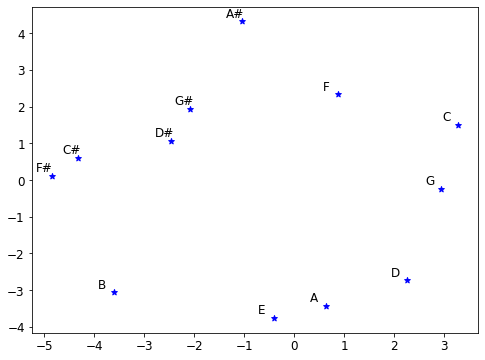

In [26]:
# plot 5th circle
plot_5th_circle(ns_model_components) #pasa los vectores luego del análisis de PCA

Observem com amb el model amb dades entrenades sense el shifteig d'acords veiem clarament la roda de cinquenes. Tot i que el cercle no és perfecte sí que s'intueix una forma circular de la disposició dels acords.